In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math

import biojepa_ac_model as model

## BioJEPA Model load

In [2]:
torch.manual_seed(1337)
random.seed(1337)

In [3]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [4]:
BATCH_SIZE = 32
n_embd = 8
n_pathways = 1024
training_file_chunk = 25000
pretraining_file_chunk = 50000
n_heads = 2
n_layers = 2

In [5]:
data_dir = Path('/Users/djemec/data/jepa/v0_2')
train_dir = data_dir / 'training'
pretrain_dir = data_dir / 'pretraining'
mask_path = data_dir / 'binary_pathway_mask.npy'
checkpoint_dir = data_dir / 'checkpoint'
pert_dir = data_dir / 'pert_embd'
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'

In [6]:
print('Loading Pathway Mask...')
binary_mask = np.load(mask_path)
n_genes, n_pathways = binary_mask.shape
print(f'Mask Loaded: {n_genes} Genes -> {n_pathways} Pathways')

print('Loading Action Embedding ...')
pert_embd = np.load(pert_embd_path)
print(f'Bank Loaded. Shape: {pert_embd.shape}')

Loading Pathway Mask...
Mask Loaded: 5000 Genes -> 1024 Pathways
Loading Action Embedding ...
Bank Loaded. Shape: (1087, 320)


In [7]:
config = model.BioJepaConfig(
    mask_matrix=binary_mask, 
    num_genes=n_genes,
    num_pathways=n_pathways,
    embed_dim=n_embd,
    n_layer=n_layers,
    heads=n_heads,
    n_pre_layer = n_layers
)
model = model.BioJepa(config, pert_embd=pert_embd).to(DEVICE)

**Load Checkpoint**

In [8]:
checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_31769_final.pt'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

**Freeze Model**

In [9]:
model.eval()
for param in model.parameters():
    param.requires_grad = False

## Build Decoder

In [10]:
@dataclass
class BenchmarkDecoderConfig:
    embed_dim: int = 384
    num_pathways: int = 1024
    num_genes: int = 4096
    
class BenchmarkDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Step 1: Collapse the embedding dimension (384 -> 1)
        # This asks: "How active is this pathway overall?"
        self.pool = nn.Linear(config.embed_dim, 1) 
        
        # Step 2: Decode Pathway Activity -> Gene Expression
        # This learns the specific contribution of each pathway to each gene
        self.decode = nn.Linear(config.num_pathways, config.num_genes) 

        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None: 
                torch.nn.init.zeros_(module.bias)
        
    def forward(self, latents):
        # latents: [Batch, 1024, 384]
        
        # 1. Calculate Pathway Scores
        # [B, 1024, 384] -> [B, 1024, 1] -> [B, 1024]
        scores = self.pool(latents).squeeze(-1)
        
        # 2. Project to Genes
        # [B, 1024] @ [1024, 2000] -> [B, 2000]
        gene_preds = self.decode(scores)
        
        return gene_preds

### Data Loader

In [11]:
def load_shard(filename):
    print(f'loading {filename}') # Optional: reduce noise
    with np.load(filename) as data:
        # Load all arrays into memory
        # We convert to correct types immediately to save hassle later
        control_x = data['control'].astype(np.float32)
        control_tot = data['control_total'].astype(np.float32)
        case_x = data['case'].astype(np.float32)
        case_tot = data['case_total'].astype(np.float32)
        action_ids = data['action_ids'].astype(np.int64)
        
    return control_x, control_tot, case_x, case_tot, action_ids

class DataLoaderLite:
    def __init__(self, B, split, device):
        self.B = B
        self.split = split
        self.device = device
        
        # 1. Find Shards
        data_root = train_dir / f'{split}'
        shards = list(data_root.glob('*.npz'))

        self.total_files = len(shards)
        self.shards = sorted(shards)

        assert len(shards) > 0, f'no shards found for split {split}'
        print(f'found {len(shards)} shards for split {split}')
        
        self.reset()

    def reset(self):
        # Create a randomized queue of shards
        self.remaining_shards = list(self.shards)
        random.shuffle(self.remaining_shards)
        
        self.current_shard_idx = -1
        self.load_next_shard()

    def load_next_shard(self):
        self.current_shard_idx += 1
        
        # If we ran out of shards, reset (Epoch done)
        if self.current_shard_idx >= len(self.remaining_shards):
            self.reset() # This resets shard_idx to -1 and reshuffles
            return 

        # Load the file
        filename = self.remaining_shards[self.current_shard_idx]
        self.data_tuple = load_shard(filename)
        
        # Shuffle the items INSIDE the shard
        # This is critical so we don't just memorize the sorted order of the shard
        n_samples = len(self.data_tuple[0])
        self.perm = np.random.permutation(n_samples)
        self.current_position = 0
        self.total_samples_in_shard = n_samples

    def next_batch(self):
        B = self.B
        
        # Check if we have enough data left in current shard
        if self.current_position + B > self.total_samples_in_shard:
            self.load_next_shard()
            # Recursively call to get batch from the new shard
            return self.next_batch()
            
        # Get indices for this batch
        indices = self.perm[self.current_position : self.current_position + B]
        self.current_position += B
        
        # Slice data using the shuffled indices
        # data_tuple structure: (xc, xct, xt, xtt, aid)
        batch_xc  = torch.from_numpy(self.data_tuple[0][indices]).to(self.device)
        batch_xct = torch.from_numpy(self.data_tuple[1][indices]).to(self.device)
        batch_xt  = torch.from_numpy(self.data_tuple[2][indices]).to(self.device)
        batch_xtt = torch.from_numpy(self.data_tuple[3][indices]).to(self.device)
        batch_aid = torch.from_numpy(self.data_tuple[4][indices]).to(self.device)
        
        return batch_xc, batch_xct, batch_xt, batch_xtt, batch_aid

**Data Loader**

In [14]:
train_loader = DataLoaderLite(B=BATCH_SIZE, split='train', device=DEVICE)
val_loader = DataLoaderLite(B=BATCH_SIZE, split='val', device=DEVICE)


found 5 shards for split train
loading /Users/djemec/data/jepa/v0_2/training/train/shard_k562e_train_0001.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/v0_2/training/val/shard_k562e_val_0000.npz


## Training Decoder

### Training Config/Setup

In [15]:
lr_decoder = 1e-2
epochs = 5

**Initialize Decoder** 

In [16]:
config = BenchmarkDecoderConfig(
    embed_dim= n_embd,
    num_pathways= n_pathways,
    num_genes= n_genes
)

decoder = BenchmarkDecoder(config).to(DEVICE)

**Optimizer**

In [17]:
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr_decoder)

**Training Lenght**

In [18]:
train_total_examples = 101682
val_total_examples = 11044
test_total_examples = 38829

In [19]:
steps_per_epoch = train_total_examples // BATCH_SIZE
max_steps = epochs * steps_per_epoch
steps_per_epoch, max_steps

(3177, 15885)

**Scheduler**

In [20]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr_decoder, total_steps=max_steps, pct_start=0.05
)

### Training Loop

In [21]:
lossi = []
step = 0
total_epoch_loss = 0

In [22]:
for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 25
            for i in range(val_loss_steps):
                cont_x, cont_tot, case_x, case_tot, act_id = val_loader.next_batch()

                # run BioJEPA
                with torch.no_grad():
                    z_context = model.student(cont_x, cont_tot)
                    z_pred = model.predictor(z_context, act_id)

                # run new decoder
                pred_delta = decoder(z_pred) - decoder(z_context)
                real_delta = case_x - cont_x

                loss = F.mse_loss(pred_delta, real_delta)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()

        print(f'val loss: {val_loss_accum.item():.4f}')


    # periodically save checkpoint
    if step > 0 and  (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}.pt')

    # actual training
    decoder.train
    cont_x, cont_tot, case_x, case_tot, act_id = train_loader.next_batch()

    # run frozen BioJEPA
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot)
        z_pred = model.predictor(z_context, act_id)

    # run decoder
    pred_delta = decoder(z_pred) - decoder(z_context)
    real_delta = case_x - cont_x
    real_delta = case_x - cont_x

    # loss
    pred_delta = decoder(z_pred) - decoder(z_context)
    real_delta = case_x - cont_x

    optimizer.zero_grad()

    loss = F.mse_loss(pred_delta, real_delta)
    loss.backward()

    optimizer.step()
    scheduler.step()

    # loss caching
    lossi.append(loss.item())
    total_epoch_loss += loss.item()

    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}_final.pt')

    step += 1

test loss: 0.9040
Step 0 | Loss: 0.93494 | LR: 4.00e-04
Step 25 | Loss: 0.92195 | LR: 4.25e-04
Step 50 | Loss: 0.90335 | LR: 4.98e-04
Step 75 | Loss: 0.92092 | LR: 6.16e-04
test loss: 0.9156
Step 100 | Loss: 0.88460 | LR: 7.79e-04
Step 125 | Loss: 0.90976 | LR: 9.85e-04
Step 150 | Loss: 0.92067 | LR: 1.23e-03
Step 175 | Loss: 0.90909 | LR: 1.52e-03
test loss: 0.9046
Step 200 | Loss: 0.92686 | LR: 1.84e-03
Step 225 | Loss: 0.90585 | LR: 2.20e-03
Step 250 | Loss: 0.93254 | LR: 2.58e-03
Step 275 | Loss: 0.88064 | LR: 2.99e-03
test loss: 0.9086
Step 300 | Loss: 0.87286 | LR: 3.43e-03
Step 325 | Loss: 0.91142 | LR: 3.87e-03
Step 350 | Loss: 0.90651 | LR: 4.34e-03
Step 375 | Loss: 0.91356 | LR: 4.81e-03
test loss: 0.8981
Step 400 | Loss: 0.89542 | LR: 5.28e-03
Step 425 | Loss: 0.85320 | LR: 5.76e-03
Step 450 | Loss: 0.88244 | LR: 6.23e-03
Step 475 | Loss: 0.84772 | LR: 6.68e-03
test loss: 0.8774
Step 500 | Loss: 0.89394 | LR: 7.13e-03
Step 525 | Loss: 0.84370 | LR: 7.55e-03
Step 550 | Loss: 

**Training Loss Plot**

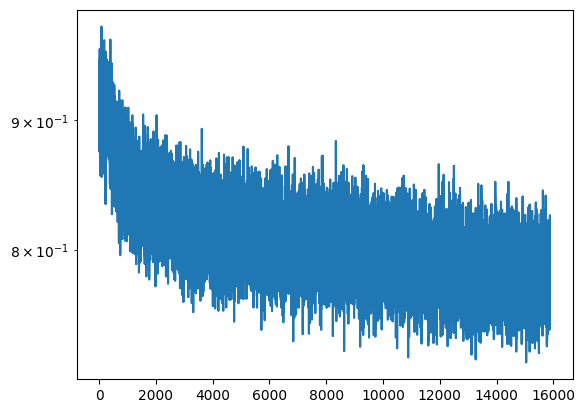

In [23]:
plt.plot(lossi)
plt.yscale('log')

## Trained Decoder Validation

In [24]:
import warnings
from scipy.stats import ConstantInputWarning

In [25]:
decoder.eval()
correlations = []
mses = []

In [26]:
val_steps_per_epoch = val_total_examples // BATCH_SIZE
test_steps_per_epoch = test_total_examples // BATCH_SIZE

In [27]:
for step in tqdm(range(val_steps_per_epoch), desc="Evaluating"):
    
    # Custom Loader Call
    cont_x, cont_tot, case_x, case_tot, act_id = val_loader.next_batch()
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot)
        z_pred = model.predictor(z_context, act_id)
        
        pred_delta = decoder(z_pred) - decoder(z_context)
        real_delta = case_x - cont_x
        
    # Per-Sample Metrics
    for i in range(len(pred_delta)):
        p = pred_delta[i].cpu().numpy()
        t = real_delta[i].cpu().numpy()
        
        # Metric: Pearson Correlation on Top 20 DEGs
        top_20_idx = np.argsort(np.abs(t))[-20:]
        
        if np.std(p[top_20_idx]) > 1e-9 and np.std(t[top_20_idx]) > 1e-9:
            
            try:
                corr, _ = pearsonr(p[top_20_idx], t[top_20_idx])
                correlations.append(corr)
            except:
                pass
            
        mses.append(np.mean((p - t)**2))

Evaluating:  41%|████████████████████████████████                                               | 140/345 [00:44<01:06,  3.08it/s]

loading /Users/djemec/data/jepa/v0_2/training/val/shard_k562e_val_0000.npz


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████| 345/345 [01:52<00:00,  3.07it/s]


In [28]:
mean_mse = np.mean(mses)
mean_corr = np.mean(correlations)
print(f'Global MSE: {mean_mse:.4f}')
print(f'Top-20 Pearson R: {mean_corr:.4f}')

Global MSE: 0.7932
Top-20 Pearson R: 0.5561


In [29]:
if mean_corr > 0.75:
    print('🌟 SOTA COMPETITIVE (Matches GEARS)')
elif mean_corr > 0.40:
    print('✅ FUNCTIONAL (Better than random)')
else:
    print('❌ NEEDS IMPROVEMENT')


✅ FUNCTIONAL (Better than random)


## Trained Decoder Evaluation

In [30]:
eval_correlations = []
eval_mses = []

In [35]:
test_loader = DataLoaderLite(B=BATCH_SIZE, split='test', device=DEVICE)
test_steps_per_epoch = test_total_examples // BATCH_SIZE


found 2 shards for split test
loading /Users/djemec/data/jepa/v0_2/training/test/shard_k562e_test_0001.npz


In [36]:
for step in tqdm(range(test_steps_per_epoch), desc="Evaluating"):
    
    # Custom Loader Call
    cont_x, cont_tot, case_x, case_tot, act_id = test_loader.next_batch()
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot)
        z_pred = model.predictor(z_context, act_id)
        
        pred_delta = decoder(z_pred) - decoder(z_context)
        real_delta = case_x - cont_x
        
    # Per-Sample Metrics
    for i in range(len(pred_delta)):
        p = pred_delta[i].cpu().numpy()
        t = real_delta[i].cpu().numpy()
        
        # Metric: Pearson Correlation on Top 20 DEGs
        top_20_idx = np.argsort(np.abs(t))[-20:]
        
        if np.std(p[top_20_idx]) > 1e-9 and np.std(t[top_20_idx]) > 1e-9:
            corr, _ = pearsonr(p[top_20_idx], t[top_20_idx])
            eval_correlations.append(corr)
            
        eval_mses.append(np.mean((p - t)**2))

Evaluating:  36%|███████████████████████████▊                                                  | 432/1213 [02:14<04:31,  2.88it/s]

loading /Users/djemec/data/jepa/v0_2/training/test/shard_k562e_test_0000.npz


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████| 1213/1213 [06:55<00:00,  2.92it/s]


In [37]:
eval_mean_mse = np.mean(eval_mses)
eval_mean_corr = np.mean(eval_correlations)
print(f'Global MSE: {eval_mean_mse:.4f}')
print(f'Top-20 Pearson R: {eval_mean_corr:.4f}')

Global MSE: 0.7904
Top-20 Pearson R: 0.5544
